# Notebook for Training the Steering Model

Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import blobconverter
import shutil, os

print("Tensorflow Version", tf.__version__)
tf.config.list_physical_devices("GPU")

Tensorflow Version 2.9.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Preprocessing

In [2]:
image_height = 135
image_width = 480
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "data",
    seed=20, 
    validation_split=0.2, 
    subset="training", 
    image_size=(image_height, image_width),
    batch_size=batch_size)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "data",
    seed=20,
    validation_split=0.2,
    subset="validation",
    image_size=(image_height, image_width),
    batch_size=batch_size)

classes = train_dataset.class_names
num_classes = len(classes)
print(classes)



Found 3464 files belonging to 3 classes.
Using 2772 files for training.
Found 3464 files belonging to 3 classes.
Using 692 files for validation.
['center', 'left', 'right']


### Example Training Images

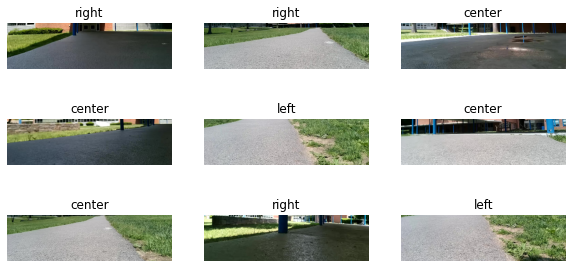

In [3]:
plt.figure(figsize=(10, 5))

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")



This step normalizes data and speeds up training

In [4]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=autotune)
test_dataset = test_dataset.cache().prefetch(buffer_size=autotune)

## Model

### Setup
Here, we will create the ML model and its layers. 

In [5]:
data_augmentation = Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
], name="DataAugmentation")

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

### Model Visualization

Data augmentation applies random transformation to the images in order to create more data



![Model Visualization](../assets/steeringmodel.png "Model")

### Training

This step trains the model over 15 epochs. 

In [6]:
epochs = 15
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/15
87/87 [==============================] - 16s 75ms/step - loss: 0.7668 - accuracy: 0.6562 - val_loss: 0.6093 - val_accuracy: 0.7832
Epoch 2/15
87/87 [==============================] - 5s 57ms/step - loss: 0.5609 - accuracy: 0.7698 - val_loss: 0.5590 - val_accuracy: 0.7861
Epoch 3/15
87/87 [==============================] - 5s 57ms/step - loss: 0.4930 - accuracy: 0.7933 - val_loss: 0.4733 - val_accuracy: 0.8107
Epoch 4/15
87/87 [==============================] - 5s 57ms/step - loss: 0.4522 - accuracy: 0.8157 - val_loss: 0.4534 - val_accuracy: 0.8194
Epoch 5/15
87/87 [==============================] - 5s 57ms/step - loss: 0.4226 - accuracy: 0.8250 - val_loss: 0.4093 - val_accuracy: 0.8280
Epoch 6/15
87/87 [==============================] - 5s 57ms/step - loss: 0.3897 - accuracy: 0.8434 - val_loss: 0.3674 - val_accuracy: 0.8454
Epoch 7/15
87/87 [==============================] - 5s 56ms/step - loss: 0.3796 - accuracy: 0.8442 - val_loss: 0.3118 - val_accuracy: 0.8584
Epoch 8/15
8

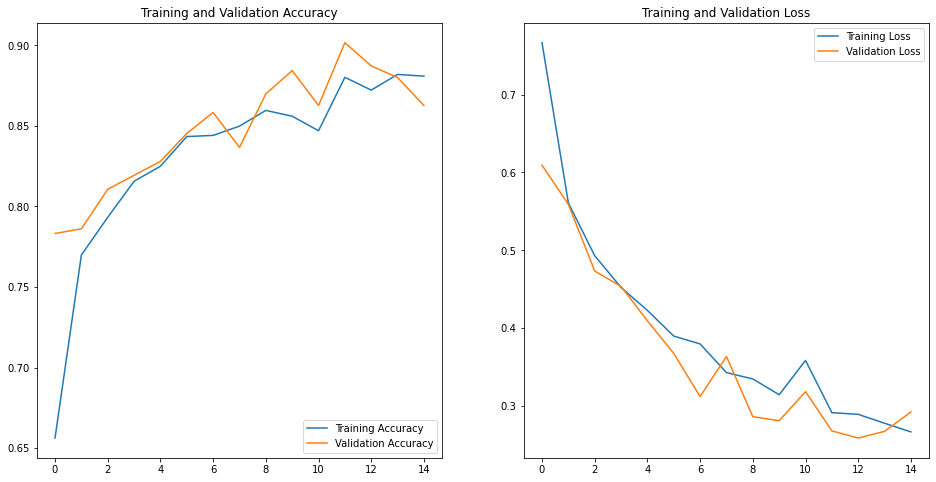

In [7]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [11]:
# Save Model

model_name="steeringmodel"
model.save(f"models/{model_name}")

INFO:tensorflow:Assets written to: models/steeringmodel\assets


INFO:tensorflow:Assets written to: models/steeringmodel\assets


## DepthAI Inferencing

### Convert model to OpenVINO IR

In [12]:
data_type = "FP16"

!mo --saved_model_dir models/$model_name --input_shape "[1,$image_height,$image_width,3]" --data_type $data_type --output_dir models/$model_name/IR_Models/$data_type --model_name $model_name

Model Optimizer arguments:

[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.22.3, required: < 1.20

Please install required versions of components or use install_prerequisites script
C:\Users\zbot4\anaconda3\envs\machinelearning\Lib\site-packages\mo\install_prerequisites\install_prerequisites_tf2.bat
Note that install_prerequisites scripts may install additional components.
[ WARNING ]  Using fallback to produce IR.



Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	c:\Users\zbot4\SelfDrivingCar\training\models/steeringmodel/IR_Models/FP16
	- IR output name: 	steeringmodel
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,135,480,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input/output node names: 	None
	- Use configuration file used to generate 

### Convert model to blob

In [13]:
blob = blobconverter.from_openvino(
    xml=f"models/{model_name}/IR_Models/{data_type}/{model_name}.xml",
    bin=f"models/{model_name}/IR_Models/{data_type}/{model_name}.bin",
    data_type="FP16",
    shaves=6,
)

os.makedirs(os.path.dirname(f"models/{model_name}/Compiled_Models/{model_name}.blob"), exist_ok=True)
shutil.move(blob, f"models/{model_name}/Compiled_Models/{model_name}.blob")


[==================================================]
Done


'models/steeringmodel/Compiled_Models/steeringmodel.blob'